In [7]:
import rasterio
from rasterio.warp import reproject
import rasterio.tools.mask
import numpy as np
import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal,osr
from fiona.crs import from_epsg
from shapely.geometry import Point,mapping, Polygon
import os
import subprocess
%matplotlib inline

In [8]:
# En el caso de Lumbumbashi no necesito mucha área, pero es bueno para implementar el asunto de la precisión
# Comparar con número inizcial de cuadritos y ya - esa es el área a llenar.
# WHY IS THE INITIAL RASTER BETTER THAN THE REPROJECTIONÇ
# WHAT IS THE DIFFERENCE BETWEEN NP.PI TIMES RADIUS SQUARE AND BUFFER.AREA????

127: not known
1: Open
2: Slope
3: Water
4: built

Original number for Lubumbashi 0.86

1. Read result raster,urban extent and EAC.
2. Crop raster in 1. with EAC.
3. Count number of pixels that are 2 or 3. That will be the number of missing pixels. A simple proportion will tell how many extra pixels are needed to account for 2 or 3 (assuming no spatial autocorrelation).
4. Extend the radius of the EAC. The new radius will be sqrt(Area/pi) where area = (original number of pixels + new number of pixels)*resolution. (Don't change resolution because it only adds noise).
(The precision should be defined by the minimum radius needed to add a new layer of pixels around the circle. Not sure if this is simple).
5. (STOP) Increase by (new number of pixels)*resolution until there are no missing numbers. 
6. Calculate index with new radius.

In [9]:
root_dir = os.getcwd()
filedir = root_dir+'/urban-expansion/Compactness/data-boundaries_allcities'
city = 'Lubumbashi'

city_path = filedir+"/"+str(city)+"/"
centroid_path = city_path + "Centroid"
urban_extent_path = city_path + "Extent"
urban_extent_t3 = gpd.read_file(city_path+'urban_edge_t3.shp')

In [10]:
# I HAVE TO DO THIS BASED ON AREA AND NOT PIXELS!!!!
# WHAT ARE THE TWO AREAS I SHOULD BE COMPARING? AREA DEL URBAN EXTENT/CIRCULO CON AREA OCUPADA POR OBSTACULOS
# CUANDO EL AREA SIN OBSTACULOS SEA IGUAL AL AREA DEL URBAN EXTENT, PARAR.

In [11]:
def new_radius(gdal_raster,urban_extent):
    initial_raster = gdal_raster.ReadAsArray()
    
    A = ((initial_raster==1)|(initial_raster==4)) # valid pixels
    A_p = ((initial_raster==2)|(initial_raster==3)) # missing pixels
    print(A_p.sum())
    B = (initial_raster!=127) # total (initial) number of pixels
    needed_pixels = float(float(A.sum())/float(B.sum()))*float(A_p.sum())
    
    initial_area = (gdal_raster.GetGeoTransform()[1]*-gdal_raster.GetGeoTransform()[5])*(B.sum())
    ue_area_original = urban_extent.area.sum()
    needed_area = (gdal_raster.GetGeoTransform()[1]*-gdal_raster.GetGeoTransform()[5])*needed_pixels
    radius_delta = np.sqrt(float(needed_area)/np.pi)
    initial_radius = np.sqrt(urban_extent.area.sum()/np.pi)#np.sqrt(float(initial_area)/np.pi)
    return radius_delta, initial_radius

57
target area
232065917.011
new valid area
231992884.27
57


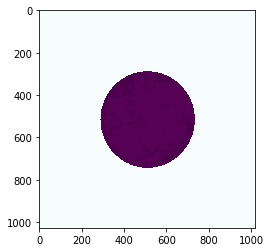

In [13]:
# -- 1.
# Adjust this for generalization.
input_raster = "1513_Lubumbashi/Lubumbashi_Result.img" 
output_raster = "1513_Lubumbashi/Lubumbashi_Result_cut.img"
output_raster_2 = "1513_Lubumbashi/Lubumbashi_Result_cut_2.img"
input_shp = "urban-expansion/Compactness/data-boundaries_allcities/Lubumbashi/Centroid/EAC_all_t3.shp"
urban_extent_t3 = gpd.read_file(city_path+'/urban_edge_t3.shp')
EAC_all_t3 = gpd.read_file("urban-expansion/Compactness/data-boundaries_allcities/Lubumbashi/Centroid/EAC_all_t3_project.shp")

## -- 2.
dss = gdal.Open(input_raster)
plt.imshow(dss.ReadAsArray(),cmap='BuPu_r')
ds=gdal.Warp(output_raster,
             dss,
             cutlineDSName = input_shp)
plt.imshow(ds.ReadAsArray(),cmap='BuPu_r')
    
initial_raster = ds.ReadAsArray()
target_area = ((initial_raster!=127)).sum()*(ds.GetGeoTransform()[1]*-ds.GetGeoTransform()[5])
previous_valid_area = target_area

## -- 3. and .4
radius_delta,initial_radius = new_radius(ds,urban_extent_t3)


# Need to save and project this beauty
new_circle = EAC_all_t3['geometry'][0].centroid.buffer((initial_radius)+radius_delta/1000)

schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

with fiona.open(centroid_path+'/new_circle.shp', 'w', 'ESRI Shapefile', schema, crs=EAC_all_t3.crs['init']) as c:
    c.write({
        'geometry': mapping(new_circle),
        'properties': {'id': 123},
    })
    
subprocess.call('''ogr2ogr -clipsrc '''+centroid_path+'''/new_circle.shp '''+centroid_path+'''/clipped_extent_t3_all_iterative.shp '''+urban_extent_path+'''/urban_extent_t3_project.shp ''',shell=True)
#clipped_extent_t3_all_iterative = gpd.read_file(centroid_path+'/clipped_extent_t3_all_iterative.shp ')

print("target area")
print(target_area)


## -- 5. 
i = 3
output_raster_2 = "1513_Lubumbashi/Lubumbashi_Result_cut_2.img"
ds_2 = gdal.Warp(output_raster_2,
                 dss,
                 cutlineDSName = centroid_path+'/new_circle.shp')

second_raster = ds_2.ReadAsArray()
new_valid_area = ((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5])

while ((np.abs(new_valid_area - target_area) < urban_extent_t3.area.sum()*0.0005) & (new_valid_area!=previous_valid_area)):
    print("new valid area")
    print(((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5]))
    ## -- 6.
    
    radius_delta,initial_radius = new_radius(ds_2,urban_extent_t3)
    
    # Need to save and project this beauty
    new_circle = EAC_all_t3['geometry'][0].centroid.buffer((initial_radius)+(i-1)*radius_delta)

    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    with fiona.open(centroid_path+'/new_circle.shp', 'w', 'ESRI Shapefile', schema, crs=EAC_all_t3.crs['init']) as c:
        c.write({
            'geometry': mapping(new_circle),
            'properties': {'id': 123},
        })

    subprocess.call('''ogr2ogr -clipsrc '''+centroid_path+'''/new_circle.shp '''+centroid_path+'''/clipped_extent_t3_all_iterative.shp '''+urban_extent_path+'''/urban_extent_t3_project.shp ''',shell=True)
  
    output_raster_2 = "1513_Lubumbashi/Lubumbashi_Result_cut_"+str(i)+".img"
    ds_2 = gdal.Warp(output_raster_2,
                     dss,
                     cutlineDSName = centroid_path+'/new_circle.shp')

    second_raster = ds_2.ReadAsArray()
    previous_valid_area = new_valid_area
    new_valid_area = ((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5])
    
    i += 1
    #EI_t3_centroid = 1.*((clipped_extent_t3_all_iterative['geometry'].area.sum()/urban_extent_t3['geometry'].area.sum()))
    


In [ ]:
(np.abs(new_valid_area - target_area))

In [ ]:
urban_extent_t3.area.sum()*0.00000000000000000005

In [ ]:
(np.abs(new_valid_area - target_area) < urban_extent_t3.area.sum()*0.0005)

In [14]:
j = 1
    
radius_delta,initial_radius = new_radius(ds_2,urban_extent_t3)

# Need to save and project this beauty
new_circle = EAC_all_t3['geometry'][0].centroid.buffer((initial_radius)+((radius_delta)/(100**(j))))


schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

with fiona.open(centroid_path+'/new_circle.shp', 'w', 'ESRI Shapefile', schema, crs=EAC_all_t3.crs['init']) as c:
    c.write({
        'geometry': mapping(new_circle),
        'properties': {'id': 123},
    })

subprocess.call('''ogr2ogr -clipsrc '''+centroid_path+'''/new_circle.shp '''+centroid_path+'''/clipped_extent_t3_all_iterative.shp '''+urban_extent_path+'''/urban_extent_t3_project.shp ''',shell=True)

output_raster_2 = "1513_Lubumbashi/Lubumbashi_Result_cut_"+str(i)+".img"
ds_2 = gdal.Warp(output_raster_2,
                 dss,
                 cutlineDSName = centroid_path+'/new_circle.shp')

second_raster = ds_2.ReadAsArray()
previous_valid_area = new_valid_area
new_valid_area = ((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5])
i += 1
j += 1
    
while ((np.abs(new_valid_area- target_area) < urban_extent_t3.area.sum()*0.0005) & (new_valid_area!=previous_valid_area)):

    ## -- 6.
    print("new valid area")
    print(((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5]))

    radius_delta,initial_radius = new_radius(ds_2,urban_extent_t3)
    #print(radius_delta,initial_radius)

    #print(EAC_all_t3['geometry'].area.sum())
    # Need to save and project this beauty
    new_circle = EAC_all_t3['geometry'][0].centroid.buffer((initial_radius)+((radius_delta)/(10000**(j))))
    #print(new_circle.area)

    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    with fiona.open(centroid_path+'/new_circle.shp', 'w', 'ESRI Shapefile', schema, crs=EAC_all_t3.crs['init']) as c:
        c.write({
            'geometry': mapping(new_circle),
            'properties': {'id': 123},
        })

    subprocess.call('''ogr2ogr -clipsrc '''+centroid_path+'''/new_circle.shp '''+centroid_path+'''/clipped_extent_t3_all_iterative.shp '''+urban_extent_path+'''/urban_extent_t3_project.shp ''',shell=True)
  
    output_raster_2 = "1513_Lubumbashi/Lubumbashi_Result_cut_"+str(i)+".img"
    ds_2 = gdal.Warp(output_raster_2,
                     dss,
                     cutlineDSName = centroid_path+'/new_circle.shp')

    second_raster = ds_2.ReadAsArray()
    previous_valid_area = new_valid_area
    new_valid_area = ((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5])
    i += 1
    j += 1
    #EI_t3_centroid = 1.*((clipped_extent_t3_all_iterative['geometry'].area.sum()/urban_extent_t3['geometry'].area.sum()))

60
new valid area
232079062.904
57
new valid area
231985580.996
57


In [115]:
((np.abs(new_valid_area- target_area) < urban_extent_t3.area.sum()*0.0005) & (new_valid_area!=previous_valid_area))

True

In [114]:
previous_valid_area

232065917.01104888

In [55]:
initial_radius + (radius_delta/100000000000.)

8395.1239409899172

In [51]:
EAC_all_t3.area.sum()

221057985.21642193

In [52]:
urban_extent_t3.area.sum()

221413500.0

In [88]:
((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5])

250332866.2308287

In [62]:
243147905.15517727/232065917.01104888

1.047753622276212

In [82]:
urban_extent_t3.area.sum()*0.00001

22141.350000000002

In [89]:
((initial_raster!=127)).sum()*(ds.GetGeoTransform()[1]*-ds.GetGeoTransform()[5])

232065917.01104888

In [79]:
((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5]) - ((initial_raster!=127)).sum()*(ds.GetGeoTransform()[1]*-ds.GetGeoTransform()[5])

-73032.741163343191

In [29]:
np.sqrt((((second_raster==4)|(second_raster==1)).sum()*(ds_2.GetGeoTransform()[1]*-ds_2.GetGeoTransform()[5]) - ((initial_raster!=127)).sum()*(ds.GetGeoTransform()[1]*-ds.GetGeoTransform()[5]))/np.pi)

1878.1656968562766

In [6]:
gdal.Warp(output_raster_2,
          dss,
          cutlineDSName = centroid_path+'/new_circle.shp')


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10dbc0090> >

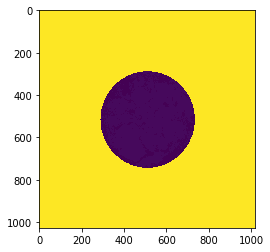

In [7]:
plt.imshow(ds.ReadAsArray())

In [8]:
EAC_all_t3.centroid

0    POINT (552347.2399649877 -1289177.211115094)
dtype: object

In [9]:
Point([0,0]).buffer(initial_radius).area

231693310.3585004

In [10]:
Point([552347.2399649877, -1289177.211115094]).buffer(initial_radius).area

231693310.35849977

In [11]:
EAC_all_t3.centroid.buffer(initial_radius).area[0]

231693310.35849977

In [12]:
new_circle.centroid.coords.xy

(array('d', [552347.2399649876]), array('d', [-1289177.2111150946]))

In [13]:
np.pi*(initial_radius)**2

232065917.01104888

In [14]:
np.pi*(initial_radius+radius_delta)**2

240938741.88002008

In [15]:
new_circle.area

240551888.9580683

In [16]:
np.sqrt((new_circle.area)/np.pi)

8750.4310976967627

In [17]:
initial_radius

8594.7004386961617

In [18]:
initial_radius+radius_delta

8757.4644449803454

In [19]:
# Initial circle - 5x the area
np.sqrt(((ds.GetGeoTransform()[1]*-ds.GetGeoTransform()[5])*np.prod((dss.ReadAsArray()!=127).sum()))/np.pi)

19543.228151313251

In [20]:
subprocess.call('''ogr2ogr -clipsrc '''+centroid_path+'''/new_circle.shp '''+centroid_path+'''/clipped_extent_t3_all_iterative.shp '''+urban_extent_path+'''/urban_extent_t3_project.shp ''',shell=True)

0

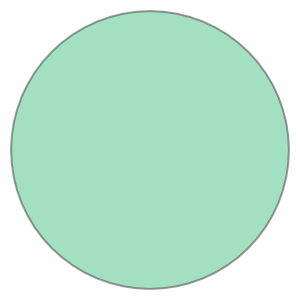

In [21]:
new_circle

In [22]:
np.sqrt(new_circle.area/np.pi)

8750.4310976967627

In [23]:
np.sqrt(urban_extent_t3.area.sum()/np.pi)

8395.1239409882892

In [15]:
(0.51 -0.38)/.51

0.2549019607843137

In [16]:
(0.68 -0.49)/.68

0.2794117647058824

In [17]:
(0.66 -0.48)/.66

0.27272727272727276